## 回归话题补充
两种不同的训练模型的方式
- 通过闭式方程，直接计算出最拟合训练集的模型参数
- 迭代优化的方式：梯度下降和它的变体：批量梯度下降，小批量梯度下降以及随机梯度下降

多种正则化技巧
- 岭回归，Lasso回归和弹性网络回归

分类任务模型
- 针对多分类的softmax回归

### 闭式方程
$$
\hat{\theta} = (X^\top X)^{-1} X^\top y
$$

这个方程中：

- $\hat{\theta}$ 是使代价函数最小的 $\theta$ 值。
- $y$ 是包含 $y^{(1)}$ 到 $y^{(m)}$ 的目标值向量。


In [1]:
# 生成假数据
import numpy as np
np.random.seed(100)

m = 100
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)

In [3]:
# 用方程拟合
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # X里 增加一列1
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[3.98485975],
       [2.86232606]])

In [4]:
# 做出预测
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new) # X_new里 增加一列1
y_predict = X_new_b @ theta_best
y_predict

array([[3.98485975],
       [9.70951187]])

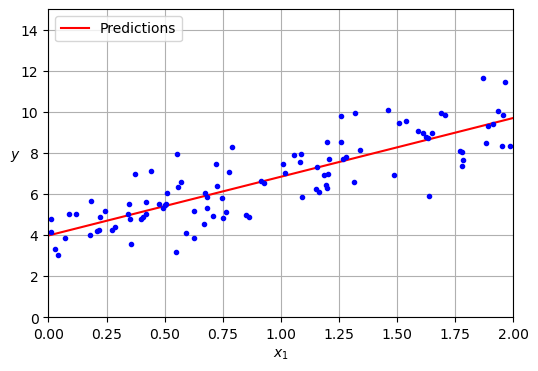

In [7]:
# 绘制预测结果
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

In [9]:
# 使用sklearn做更简单了
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_
lin_reg.predict(X_new)

array([[3.98485975],
       [9.70951187]])

In [10]:
# LinearRegression类基于 np.linalg.lstsq()函数，可以直接调用它
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.98485975],
       [2.86232606]])

In [11]:
# 上面的函数计算的是 X的伪逆(np.linalg.pinv(), Moore-Penrose逆） 和 y的矩阵乘法
np.linalg.pinv(X_b) @ y

array([[3.98485975],
       [2.86232606]])

伪逆本身是使用被称为奇异值分解(Singular Value Decomposition，SVD)的标准矩阵分解技术来计算的，可以分解训练集矩阵X为三个矩阵UΣV⊤的乘积［numpy.linalg.svd()］。伪逆的计算公式为：X+=VΣ+U⊤。为了计算矩阵Σ+，该算法取Σ并将所有小于一个小阈值的值设置为零，然后将所有非零值替换成它们的倒数，最后把结果矩阵转置。这种方法比计算标准方程更有效，而且它可以很好地处理边缘情况：的确，标准方程可能没有解，如果矩阵X⊤X是不可逆的（即奇异的），例如如果m＜n或某些特征是多余的，但伪逆总是有定义的。

#### 计算复杂度
标准方程计算$X^⊤X$的逆，是一个(n+1)×(n+1)的矩阵（n是特征数量）。对这种矩阵求逆的计算复杂度通常为O(n^2.4)到O(n^3)之间，取决于具体实现。换句话说，如果将特征数量翻倍，那么计算时间将乘以大约2^2.4=5.3倍到2^3=8倍。Scikit-Learn的LinearRegression类使用的SVD方法复杂度约为O(n^2)。如果你将特征数量加倍，那计算时间大约是原来的4倍。

特征数量比较大（例如100000）时，标准方程和SVD的计算将极其缓慢。好的一面是，相对于训练集中的实例数量[O(m)]来说，两个都是线性的，所以能够有效地处理大量的训练集，只要内存足够。同样，线性回归模型一经训练（不论是标准方程还是其他算法）​，预测就非常快速：因为计算复杂度相对于想要预测的实例数量和特征数量来说，都是线性的。换句话说，对两倍的实例（或者是两倍的特征）进行预测，大概需要两倍的时间。

### 梯度下降
- 更适合特征数量或者训练实例数量大到内存无法满足要求的场景。

- 要点复习：不同尺度的特征梯度下降速度不一样，应用梯度下降时，需要保证所有特征值的大小比例都差不多（Sklearn的StandardScaler类），否则收敛的时间会长很多
![有和没有特征缩放的梯度下降](./images/regression/p1.png)

左边的训练集特征1和特征2有相同的数值规模，而右边的训练集上，特征1的值比特征2要小得多。（因为特征1较小，需要比特征2有更大的变化才能影响代价函数，这也是被拉长的特征是更小的特征的原因）

In [17]:
# 批量梯度下降算法快速实现
eta = 0.1 # 学习率
n_epochs = 1000
m = len(X_b)

np.random.seed(100)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    gradients = X_b.T @ (X_b @ theta - y) / m
    theta = theta - eta * gradients


In [18]:
theta

array([[3.9848596],
       [2.8623262]])

#### 随机梯度下降(Stochastic Gradient Descent)


批量梯度下降的主要问题是它要用整个训练集来计算每一步的梯度，所以当训练集很大时，算法会特别慢。与之相反的极端是随机梯度下降，随机梯度下降每一步在训练集中随机选择一个实例，并且仅基于该单个实例来计算梯度。显然，这让算法变得快多了，因为每个迭代都只需要操作少量的数据。它也可以被用来训练海量的数据集，因为每次迭代只需要在内存中运行一个实例（SGD可以作为核外算法实现，大量数据无法一次载入内存，分批训练）。另外，由于算法的随机性质，它比批量梯度下降要不规则得多。代价函数将不再是缓缓降低直到抵达最小值，而是不断上上下下，但是从整体来看，还是在慢慢下降。随着时间推移，代价函数最终会非常接近最小值，但是即使它到达了最小值，依旧会持续反弹，永远不会停止。一旦算法停止，最终的参数值会很好，但不是最优的。

![随机梯度下降的路线图](./images/regression/p2.png)

当代价函数非常不规则时，随机梯度下降其实可以帮助算法跳出局部最小值，所以相比批量梯度下降，它对找到全局最小值更有优势。因此，随机性的好处在于可以逃离局部最优，但缺点是永远定位不出最小值。

要解决这个困境，有一个办法是逐步降低学习率。开始的步长比较大（这有助于快速进展和逃离局部最小值），然后越来越小，让算法尽量靠近全局最小值。这个过程叫作模拟退火，因为它类似于冶金时熔化的金属慢慢冷却的退火过程。确定每个迭代学习率的函数叫作学习率调度。如果学习率降得太快，可能会陷入局部最小值，甚至停留在走向最小值的半途中。如果学习率降得太慢，你需要很长时间才能跳到最小值附近，如果提早结束训练，可能只得到一个次优的解决方案。

学习率调度理解：eta = 1.0 / (alpha * (t + t0))； t0和alpha两个超参数需要提前确定； 或者是 按 eta = eta0 / (1+k*t)理解, eta0是初始学习率，k是衰减的速度

In [19]:
# 有学习率调度的随机梯度下降实现

n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(100)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = xi.T @ (xi @ theta - yi)  # 单个样本的梯度 不需要除以m
        eta = learning_schedule(epoch*m + iteration)
        theta = theta - eta * gradients


In [22]:
theta

array([[3.98380275],
       [2.87435455]])

用随机梯度下降时，训练实例必须独立且在同一个概率分布下(Independent and Identically Distributed，IID)，以确保平均而言将参数拉向全局最优值。确保这一点的一种简单方法是在训练过程中对实例进行随机混洗（例如，随机选择每个实例，或者在每个轮次开始时随机混洗训练集）。如果不对实例进行混洗（例如，如果实例按标签排序）​，那么SGD将首先针对一个标签进行优化，然后针对下一个标签进行优化，以此类推，并且它不会接近全局最小值。

要使用带有Scikit-Learn的随机梯度下降执行线性回归，可以使用SGDRegressor类，该类默认优化MSE代价函数。以下代码最多可运行1000个轮次(max_iter)，或者直到 连续100个轮次训练后，损失下降小于10-5(tol)为止(n_iter_no_change)。它使用默认的学习调度（与前一个使用的不同）以0.01(eta0)的学习率开始（eta0/迭代次数)。最后，它不使用任何正则化（penalty=None）

In [25]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state=100)
# sgd_reg.fit(X, y) # DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([3.98345809]), array([2.86442731]))

#### 小批量梯度下降（Mini-Batch gradient descent)

最后一个梯度下降算法变体称为小批量梯度下降。了解了批量和随机梯度下降后，就很容易理解它：在每一步中，不是根据完整的训练集（如批量GD）或仅基于一个实例（如随机GD）来计算梯度，小批量GD在称为小型批量的随机实例集上计算梯度。小批量GD优于随机GD的主要优点是，可以通过矩阵操作的硬件优化来提高性能，特别是在使用GPU时。

与随机GD相比，该算法在参数空间上的进展更稳定，尤其是在相当大的小批次中。小批量GD最终将比随机GD走得更接近最小值，但它可能很难摆脱局部最小值（在受局部最小值影响的情况下，不像有MSE代价函数的线性回归）。下图展示了训练期间参数空间中三种梯度下降算法所采用的路径。它们最终都接近最小值，但是批量GD的路径实际上是在最小值处停止，而随机GD和小批量GD都继续走动。但是，要记住批量GD每步需要花费很多时间，如果使用了良好的学习率调度，则随机GD和小批量GD也会达到最小值。

![不同梯度下降在参数空间中的路径](./images/regression/p3.png)

- 线性回归算法的比较

![线性回归的算法比较](./images/regression/p4.png)